# Try to add a nifty model for sampling the input map

2.1.1


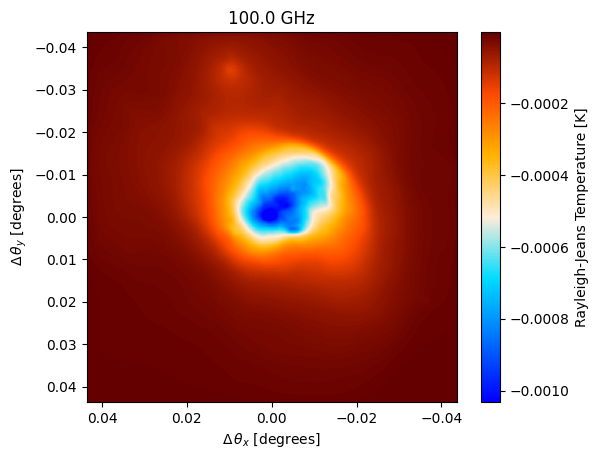

In [1]:
import scipy as sp
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

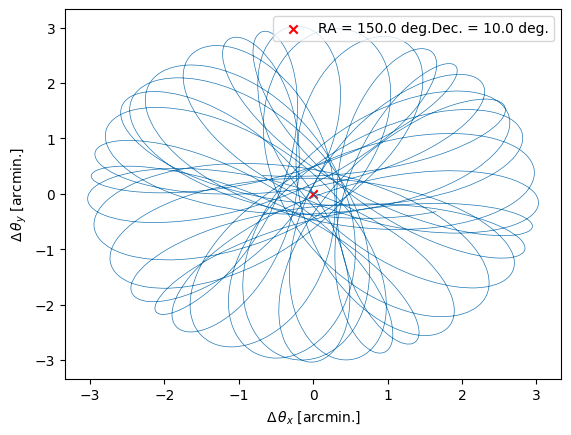

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                # atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

2024-10-02 10:45:49.878 INFO: Constructed instrument.
2024-10-02 10:45:49.878 INFO: Constructed plan.
2024-10-02 10:45:49.880 INFO: Constructed site.
2024-10-02 10:45:50.470 INFO: Constructed boresight.
2024-10-02 10:45:50.877 INFO: Constructed offsets.


Initialized base in 999 ms.


Sampling map (m2/f093): 100%|██████████| 1/1 [00:10<00:00, 10.56s/it]


In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96240674e-04, -1.93347998e-04, -1.89985390e-04, ...,
         4.73739401e-04,  4.76764109e-04,  4.80085936e-04],
       [-2.45368526e-04, -2.42476087e-04, -2.39113735e-04, ...,
         4.28384607e-04,  4.31409053e-04,  4.34730605e-04],
       [-1.21051829e-04, -1.18159199e-04, -1.14796645e-04, ...,
         5.49616894e-04,  5.52641566e-04,  5.55963347e-04],
       ...,
       [ 1.21593319e-04,  1.24487940e-04,  1.27852648e-04, ...,
         7.60700211e-04,  7.63727048e-04,  7.67051118e-04],
       [-4.04728598e-04, -4.01833655e-04, -3.98468568e-04, ...,
         2.29557762e-04,  2.32584850e-04,  2.35909239e-04],
       [-7.45629448e-04, -7.42736970e-04, -7.39374550e-04, ...,
        -7.22351429e-05, -6.92107429e-05, -6.58891924e-05]])

Running mapper (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

Running mapper (m2/f093): 100%|██████████| 1/1 [00:10<00:00, 10.90s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


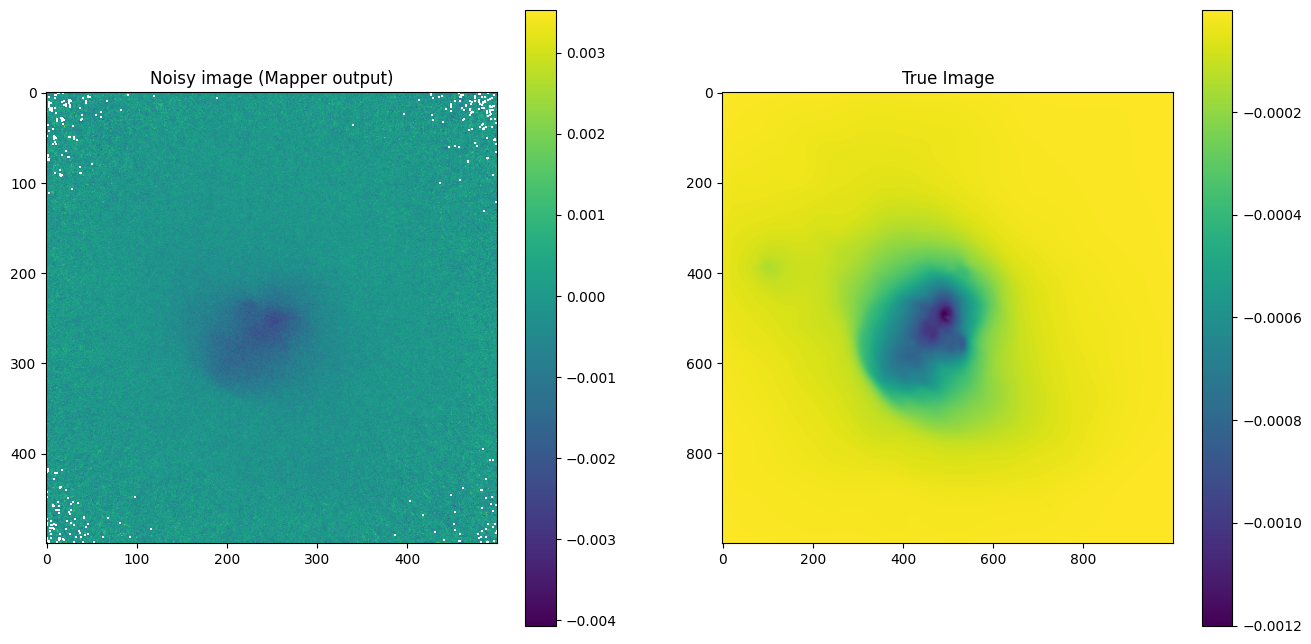

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-10-02 10:46:19.192 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-02 10:46:19.194 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [8]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [9]:
from maria.constants import k_B
from maria.instrument import beams

@jax.jit
def sample_maps(sim_truthmap, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            sim_truthmap,
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)


        nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        power_map = (
            1e12
            * k_B
            * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            # Need to invert x_side and y_side for jax interpolation:
            (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
            # jax.numpy.flip(sim_truthmap[0]),
            jax.numpy.flip(filtered_power_map), # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

## Test TOD agreement for noise-free map

(200, 200)


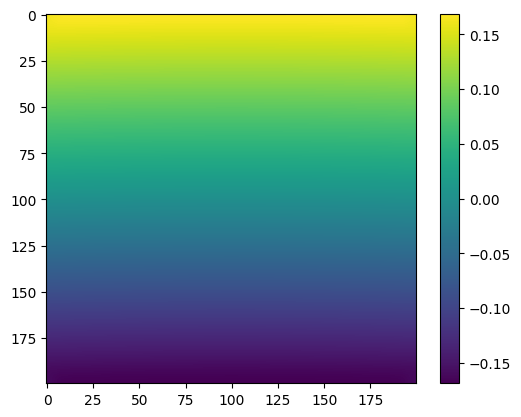

In [10]:
atmosdata_truth = np.float64(np.load('atmosphere.npy')[:, :, 0])

# pad img with average
# atmosdata_truth = np.pad(atmosdata_truth, pad_width=5, mode='constant', constant_values=atmosdata_truth.mean())

print(atmosdata_truth.shape)
plt.imshow(atmosdata_truth - atmosdata_truth.mean())
plt.colorbar()

In [11]:
# x_side = np.float64(np.linspace(-0.05, 0.05, 200))
# y_side = np.float64(np.linspace(-0.05, 0.05, 200))

x_side = np.float64(np.linspace(sim_truthmap.map.x_side.max()*2., sim_truthmap.map.x_side.min()*2., 200))
y_side = np.float64(np.linspace(sim_truthmap.map.y_side.max()*2., sim_truthmap.map.y_side.min()*2., 200)) # Ordering of x_side and y_side matters!

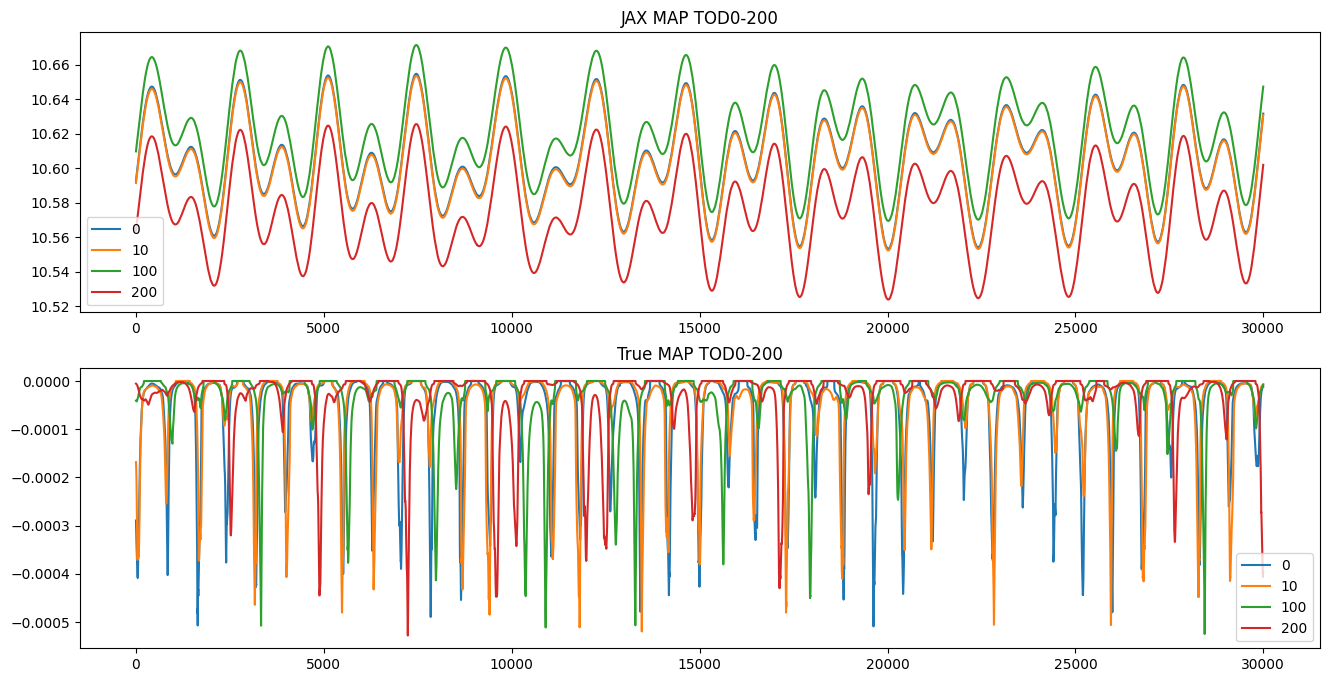

In [12]:
# jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
jax_tods = sample_maps(atmosdata_truth[np.newaxis, :, :], dx, dy, sim_truthmap.map.resolution, x_side, y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Next, initialise nifty prior model

Noise stddev: 0.0002519292


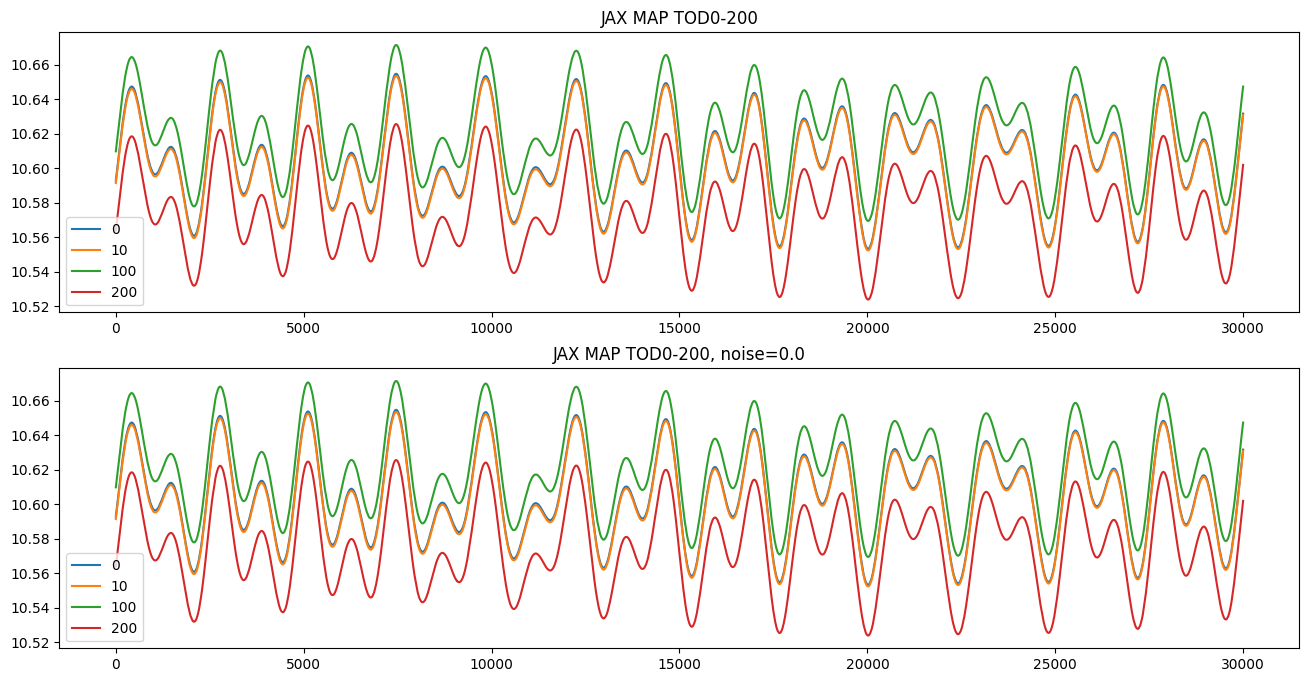

In [13]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
noised_jax_tod = jax_tods + np.float64(tod_truthmap.components['noise']*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    im1 = axes[1].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'JAX MAP TOD0-{i}, noise={noiselevel}')
axes[1].legend()

plt.show()

In [14]:
# dims = (1000, 1000)
# dims = (1024, 1024)
# dims = (200, 200)
# dims = (220, 220)
dims = (300, 300)
padding = dims[0] - atmosdata_truth.shape[0]
# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
# cf_zm_map = dict(offset_mean=1.3e-4, offset_std=(5e-5, 5e-5))
cf_zm_map = dict(offset_mean=atmosdata_truth.mean(), offset_std=(atmosdata_truth.mean()/10., atmosdata_truth.mean()/10.))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    # fluctuations=(1e-3, 1e-4), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    # loglogavgslope=(-3e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    # fluctuations=(1e-2, 2e-3), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    fluctuations=(atmosdata_truth.max() - atmosdata_truth.mean(), (atmosdata_truth.max()-atmosdata_truth.mean())/2.),
    loglogavgslope=(-5e0, 2e0), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [15]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        # return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        return sample_maps(self.gp_map(x)[jax.numpy.newaxis, padding//2:-padding//2, padding//2:-padding//2], dx, dy, sim_truthmap.map.resolution, x_side, y_side)
        # return sample_maps(self.gp_map(x)[jax.numpy.newaxis, :, :], dx, dy, sim_truthmap.map.resolution, x_side, y_side)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
noise_cov_inv_map = lambda x: 1e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
# lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
lh_tod = jft.Gaussian( noised_jax_tod, noise_cov_inv_tod).amend(signal_response_tod)
# lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [16]:
key, sub = random.split(key)
# print(lh_map_grad(jft.random_like(sub, lh_map.domain)))
print(lh_tod_grad(jft.random_like(sub, lh_tod.domain)))

Vector(
	{'cfmapax1fluctuations': Array(-2.23264306e+20, dtype=float64),
	 'cfmapax1loglogavgslope': Array(2.3545791e+20, dtype=float64),
	 'cfmapxi': Array([[-1.76391150e+22,  2.69515319e+20, -3.17833065e+19, ...,
	        -6.60881271e+17, -2.35386191e+19,  2.48967308e+20],
	       [ 2.48936126e+20, -9.72054777e+19,  1.45833941e+19, ...,
	         1.89051431e+17,  1.41761045e+19, -9.83029273e+19],
	       [-2.66873940e+19,  1.26431657e+19, -4.77387852e+17, ...,
	         5.34429857e+17, -3.71644800e+18,  1.68824505e+19],
	       ...,
	       [ 1.67027999e+18, -1.36012627e+18,  3.62944124e+17, ...,
	        -1.23611141e+17, -3.80588519e+17, -2.99195370e+17],
	       [-3.21877112e+19,  2.08658592e+19, -4.91363877e+18, ...,
	        -4.62096286e+17, -1.94627372e+18,  1.64455780e+19],
	       [ 2.72468491e+20, -1.15946029e+20,  2.08430138e+19, ...,
	         8.31486016e+17,  1.31334225e+19, -1.01198705e+20]],      dtype=float64),
	 'cfmapzeromode': Array(2.53909329e+21, dtype=float64)}
)


# Draw Prior sample

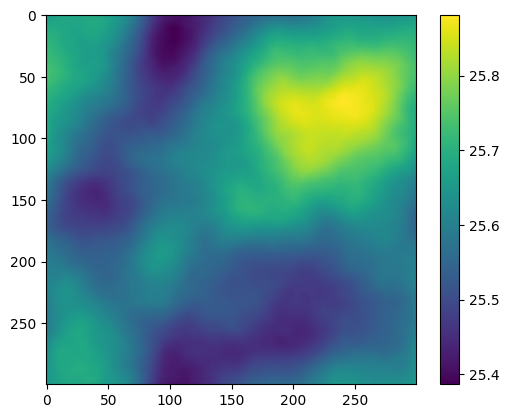

In [17]:
key = random.PRNGKey(123)
key, subkey = jax.random.split(key)
xi = jft.random_like(subkey, gp_map.domain)
res = gp_map(xi)

plt.imshow(res)
plt.colorbar()

In [18]:
todlist_prior = []

for i in range(5):
    key, subkey = jax.random.split(key)
    xi = jft.random_like(subkey, gp_map.domain)
    tod1 = signal_response_tod(xi)
    todlist_prior.append(tod1)
    
    
mean, std = jft.mean_and_std(tuple(todlist_prior))

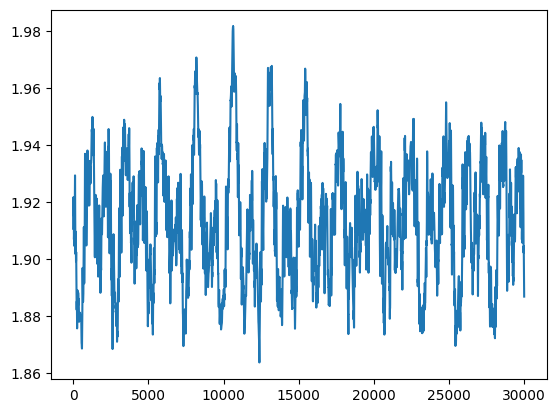

In [19]:
plt.plot(std[0])

# MAP fit

In [20]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:9.964343e+00 ➽:9.000300e+00
M: Iteration 1 ⛰:+1.042603e+19 Δ⛰:6.210847e+19
M: →:1.0 ↺:False #∇²:12 |↘|:1.080189e+01 ➽:9.000300e+00
M: Iteration 2 ⛰:+3.250218e+17 Δ⛰:1.010101e+19
M: →:1.0 ↺:False #∇²:18 |↘|:2.788216e+00 ➽:9.000300e+00
M: Iteration 3 ⛰:+1.581941e+17 Δ⛰:1.668277e+17
OPTIMIZE_KL: Iteration 0001 ⛰:+1.5819e+17
OPTIMIZE_KL: #(KL minimization steps) 3
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 4.9e+10±     0.0, avg:   -5e+03±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
cfmapax1fluctuations    :: 'reduced χ²:     2.1±     0.0, avg:     -1.5±     0.0, #dof:      1'
cfmapax1loglogavgslope  :: 'reduced χ²:    0.28±     0.0, avg:    -0.53±     0.0, #dof:      1'
cfmapxi                 :: 'reduced χ²:     1.0±     0.0, avg: -0.00044±     0.0, #dof:  90000'
cfmapzeromode           :: 'reduced χ²:   0.093±     0.0, avg:     -0.3±     0.0, #dof:      1'




In [21]:
def printfitresults():
    print("Fit Results (res, init, std)")
    print(f"fluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    print(f"loglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    print(f"zeromode: {jft.LogNormalPrior(cf_zm_map['offset_mean'], cf_zm_map['offset_std'][0])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_mean']}, {cf_zm_map['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)
fluctuations: 0.07566453226348642, 0.16871608827074525, 0.08435804413537262
loglogvarslope: -6.063471844950449, -5.0, 2.0
zeromode: 20.227269306646793, 20.95525829052564, 2.0955258290525642


(200, 200)


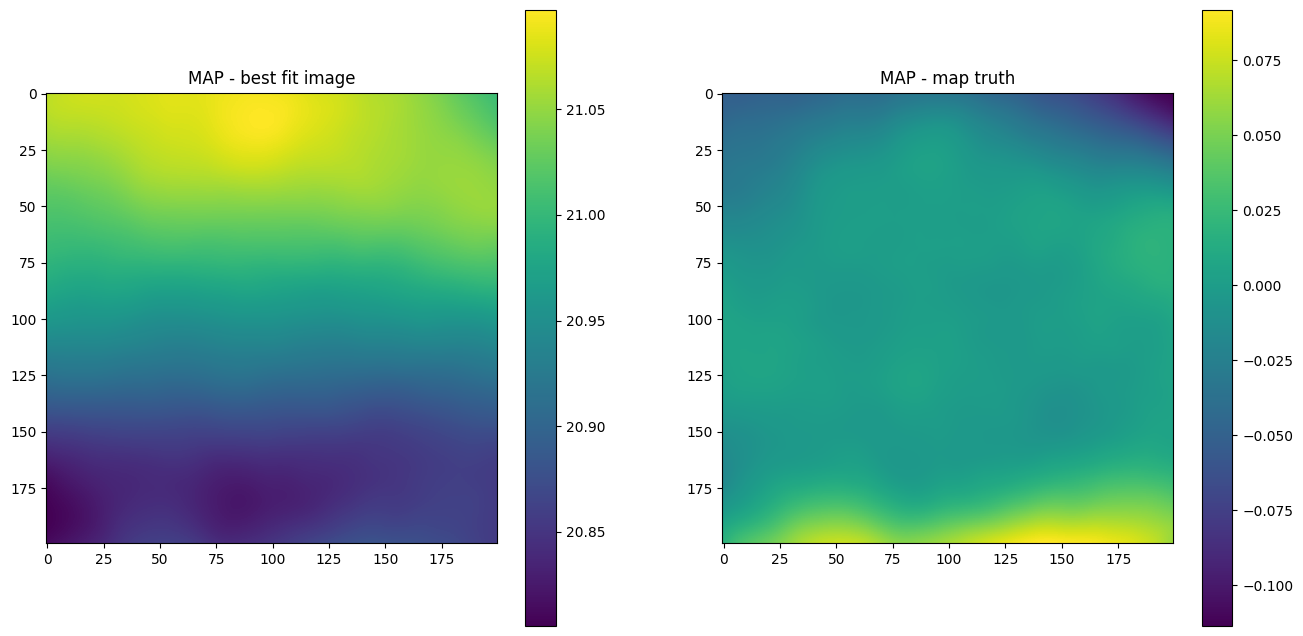

In [22]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos)[padding//2:-padding//2, padding//2:-padding//2] # when splitting up in different field models
# sig_map = gp_map(samples.pos) # when splitting up in different field models
print(sig_map.shape)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

# im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
im1 = axes[1].imshow( sig_map - atmosdata_truth )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

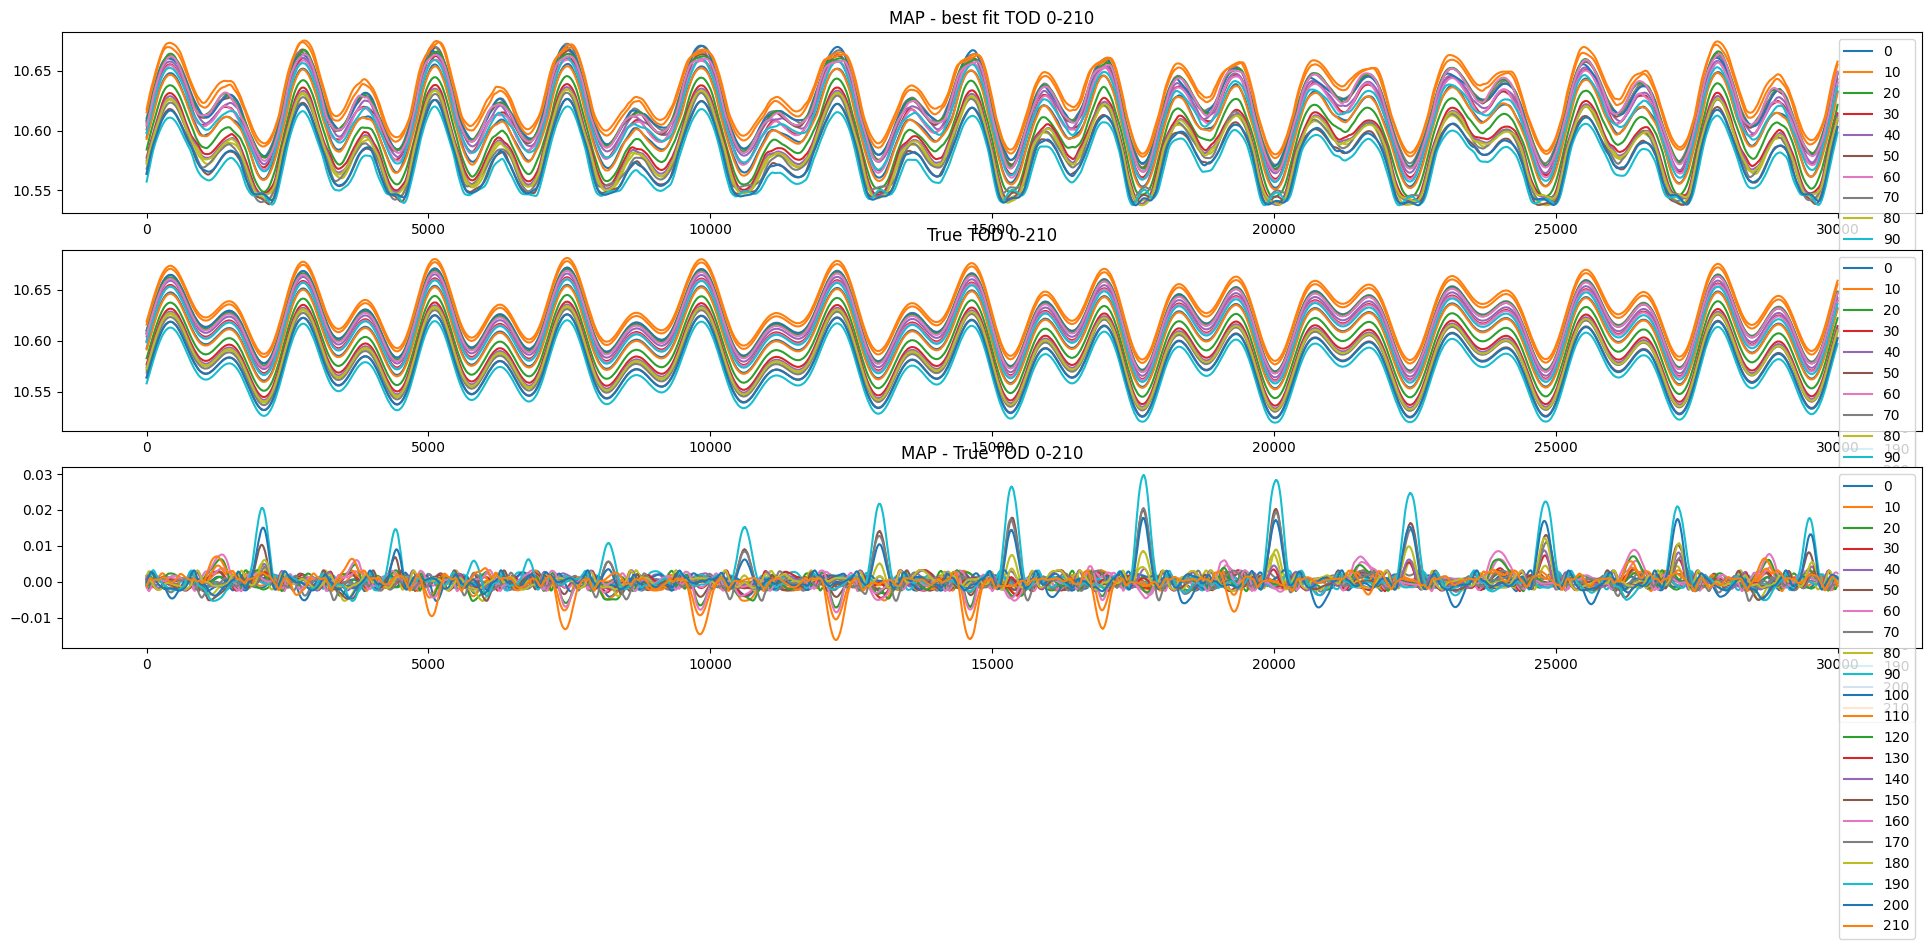

In [23]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(3, 1, figsize=(8*3, 8))

# for i in [0, 10, 100, 200]:
for i in range(0, len(jax_tods), len(jax_tods)//20):
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    im2 = axes[2].plot(pred_tods[i] - jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()
axes[2].title.set_text(f'MAP - True TOD 0-{i}')
axes[2].legend()

plt.show()

In [24]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+2.6858e+22 Δ⛰:inf ➽:9.0003e-02
SL: Iteration 1 ⛰:+4.6782e+19 Δ⛰:2.6811e+22 ➽:9.0003e-02
SL: Iteration 2 ⛰:+2.4682e+19 Δ⛰:2.2101e+19 ➽:9.0003e-02
SL: Iteration 3 ⛰:+1.5435e+19 Δ⛰:9.2460e+18 ➽:9.0003e-02
SL: Iteration 4 ⛰:+1.0368e+19 Δ⛰:5.0672e+18 ➽:9.0003e-02
SL: Iteration 5 ⛰:+1.0368e+19 Δ⛰:5.3496e+14 ➽:9.0003e-02
SL: Iteration 6 ⛰:+8.1949e+18 Δ⛰:2.1728e+18 ➽:9.0003e-02
SL: Iteration 7 ⛰:+6.0497e+18 Δ⛰:2.1452e+18 ➽:9.0003e-02
SL: Iteration 8 ⛰:+4.4228e+18 Δ⛰:1.6269e+18 ➽:9.0003e-02
SL: Iteration 9 ⛰:+3.8752e+18 Δ⛰:5.4762e+17 ➽:9.0003e-02
SL: Iteration 10 ⛰:+3.6861e+18 Δ⛰:1.8910e+17 ➽:9.0003e-02
SL: Iteration 11 ⛰:+2.7171e+18 Δ⛰:9.6901e+17 ➽:9.0003e-02
SL: Iteration 12 ⛰:+2.0858e+18 Δ⛰:6.3126e+17 ➽:9.0003e-02
SL: Iteration 13 ⛰:+1.9398e+18 Δ⛰:1.4600e+17 ➽:9.0003e-02
SL: Iteration 14 ⛰:+1.7898e+18 Δ⛰:1.4999e+17 ➽:9.0003e-02
SL: Iteration 15 ⛰:+1.3705e+18 Δ⛰:4.1932e+17 ➽:9.0003e-02
SL: Iteration 16 ⛰:+1.2012e+18 Δ⛰:1.6932e+17 ➽:9.0003e-02
SL: 

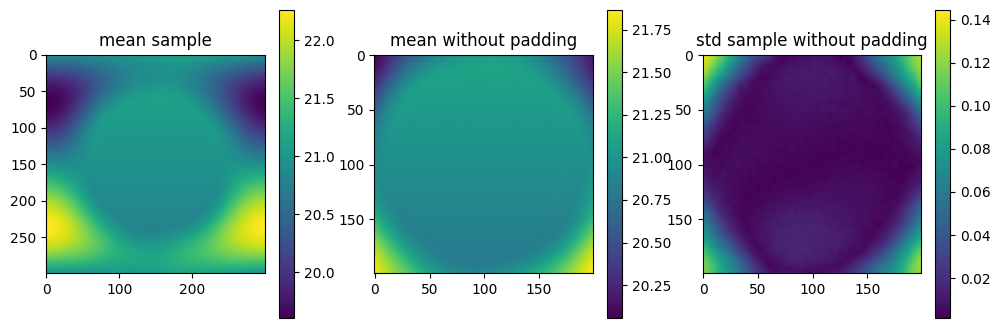

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+5.1116e+18 Δ⛰:inf ➽:9.0003e-02
SL: Iteration 1 ⛰:+3.3308e+18 Δ⛰:1.7808e+18 ➽:9.0003e-02
SL: Iteration 2 ⛰:+1.6778e+18 Δ⛰:1.6530e+18 ➽:9.0003e-02
SL: Iteration 3 ⛰:+8.3436e+17 Δ⛰:8.4346e+17 ➽:9.0003e-02
SL: Iteration 4 ⛰:+4.6312e+17 Δ⛰:3.7124e+17 ➽:9.0003e-02
SL: Iteration 5 ⛰:+3.0539e+17 Δ⛰:1.5773e+17 ➽:9.0003e-02
SL: Iteration 6 ⛰:+1.8059e+17 Δ⛰:1.2480e+17 ➽:9.0003e-02
SL: Iteration 7 ⛰:+1.4858e+17 Δ⛰:3.2003e+16 ➽:9.0003e-02
SL: Iteration 8 ⛰:+1.4598e+17 Δ⛰:2.6016e+15 ➽:9.0003e-02
SL: Iteration 9 ⛰:+1.1537e+17 Δ⛰:3.0615e+16 ➽:9.0003e-02
SL: Iteration 10 ⛰:+1.0227e+17 Δ⛰:1.3095e+16 ➽:9.0003e-02
SL: Iteration 11 ⛰:+7.5300e+16 Δ⛰:2.6973e+16 ➽:9.0003e-02
SL: Iteration 12 ⛰:+7.5124e+16 Δ⛰:1.7584e+14 ➽:9.0003e-02
SL: Iteration 13 ⛰:+6.3637e+16 Δ⛰:1.1487e+16 ➽:9.0003e-02
SL: Iteration 14 ⛰:+5.0151e+16 Δ⛰:1.3485e+16 ➽:9.0003e-02
SL: Iteration 15 ⛰:+4.9676e+16 Δ⛰:4.7500e+14 ➽:9.0003e-02
SL: Iteration 16 ⛰:+4.4175e+16 Δ⛰:5.5011e+15 ➽:9.0003e-02
SL: 

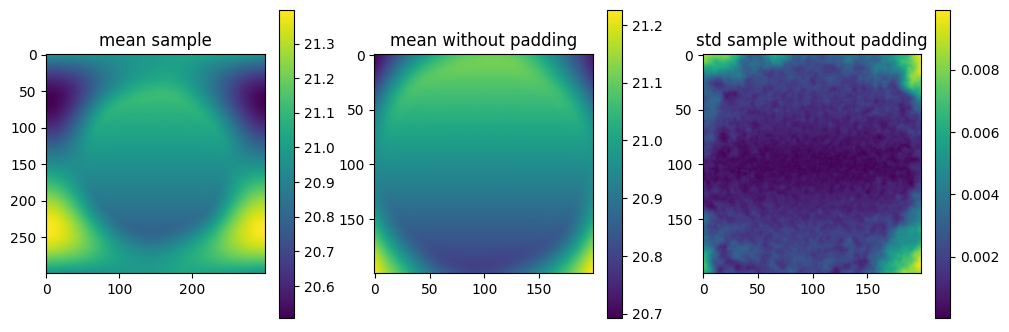

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+4.4256e+18 Δ⛰:inf ➽:9.0003e-02
SL: Iteration 1 ⛰:+9.3465e+17 Δ⛰:3.4909e+18 ➽:9.0003e-02
SL: Iteration 2 ⛰:+3.8968e+17 Δ⛰:5.4497e+17 ➽:9.0003e-02
SL: Iteration 3 ⛰:+1.2560e+17 Δ⛰:2.6408e+17 ➽:9.0003e-02
SL: Iteration 4 ⛰:+4.8343e+16 Δ⛰:7.7255e+16 ➽:9.0003e-02
SL: Iteration 5 ⛰:+2.6185e+16 Δ⛰:2.2158e+16 ➽:9.0003e-02
SL: Iteration 6 ⛰:+1.7769e+16 Δ⛰:8.4167e+15 ➽:9.0003e-02
SL: Iteration 7 ⛰:+1.4999e+16 Δ⛰:2.7698e+15 ➽:9.0003e-02
SL: Iteration 8 ⛰:+1.2185e+16 Δ⛰:2.8136e+15 ➽:9.0003e-02
SL: Iteration 9 ⛰:+1.2016e+16 Δ⛰:1.6898e+14 ➽:9.0003e-02
SL: Iteration 10 ⛰:+1.1148e+16 Δ⛰:8.6871e+14 ➽:9.0003e-02
SL: Iteration 11 ⛰:+1.1139e+16 Δ⛰:8.2957e+12 ➽:9.0003e-02
SL: Iteration 12 ⛰:+8.2581e+15 Δ⛰:2.8813e+15 ➽:9.0003e-02
SL: Iteration 13 ⛰:+7.0911e+15 Δ⛰:1.1670e+15 ➽:9.0003e-02
SL: Iteration 14 ⛰:+7.0296e+15 Δ⛰:6.1533e+13 ➽:9.0003e-02
SL: Iteration 15 ⛰:+5.9699e+15 Δ⛰:1.0597e+15 ➽:9.0003e-02
SL: Iteration 16 ⛰:+5.9684e+15 Δ⛰:1.4763e+12 ➽:9.0003e-02
SL: 

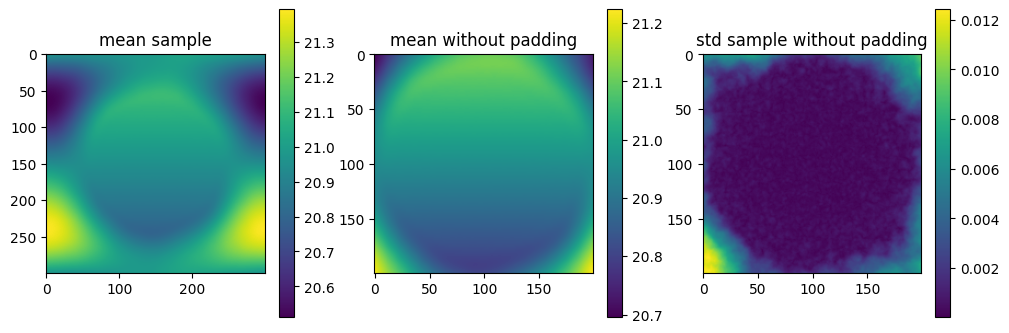

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+8.5854e+18 Δ⛰:inf ➽:9.0003e-02
SL: Iteration 1 ⛰:+1.0194e+18 Δ⛰:7.5660e+18 ➽:9.0003e-02
SL: Iteration 2 ⛰:+4.3567e+17 Δ⛰:5.8377e+17 ➽:9.0003e-02
SL: Iteration 3 ⛰:+1.3739e+17 Δ⛰:2.9827e+17 ➽:9.0003e-02
SL: Iteration 4 ⛰:+8.7685e+16 Δ⛰:4.9709e+16 ➽:9.0003e-02
SL: Iteration 5 ⛰:+5.2435e+16 Δ⛰:3.5250e+16 ➽:9.0003e-02
SL: Iteration 6 ⛰:+2.5902e+16 Δ⛰:2.6534e+16 ➽:9.0003e-02
SL: Iteration 7 ⛰:+2.0602e+16 Δ⛰:5.2997e+15 ➽:9.0003e-02
SL: Iteration 8 ⛰:+1.7271e+16 Δ⛰:3.3308e+15 ➽:9.0003e-02
SL: Iteration 9 ⛰:+1.4088e+16 Δ⛰:3.1827e+15 ➽:9.0003e-02
SL: Iteration 10 ⛰:+1.2241e+16 Δ⛰:1.8470e+15 ➽:9.0003e-02
SL: Iteration 11 ⛰:+1.2229e+16 Δ⛰:1.2283e+13 ➽:9.0003e-02
SL: Iteration 12 ⛰:+9.5832e+15 Δ⛰:2.6460e+15 ➽:9.0003e-02
SL: Iteration 13 ⛰:+8.1933e+15 Δ⛰:1.3898e+15 ➽:9.0003e-02
SL: Iteration 14 ⛰:+8.1377e+15 Δ⛰:5.5591e+13 ➽:9.0003e-02
SL: Iteration 15 ⛰:+7.3145e+15 Δ⛰:8.2321e+14 ➽:9.0003e-02
SL: Iteration 16 ⛰:+6.8974e+15 Δ⛰:4.1713e+14 ➽:9.0003e-02
SL: 

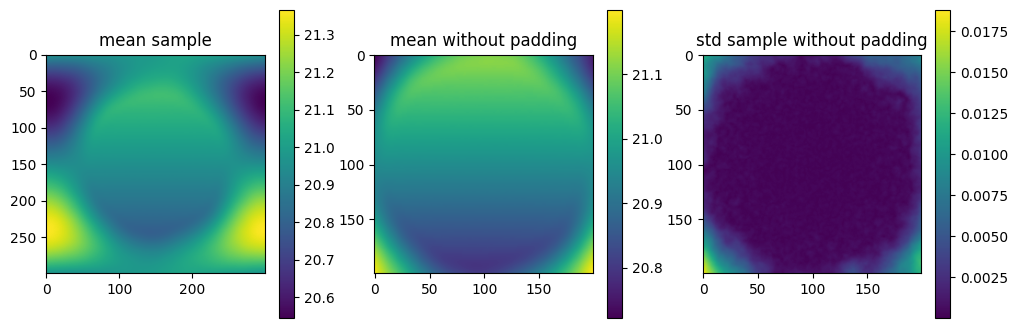

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+1.4871e+19 Δ⛰:inf ➽:9.0003e-02
SL: Iteration 1 ⛰:+5.0098e+18 Δ⛰:9.8613e+18 ➽:9.0003e-02
SL: Iteration 2 ⛰:+8.7336e+17 Δ⛰:4.1364e+18 ➽:9.0003e-02
SL: Iteration 3 ⛰:+1.4831e+17 Δ⛰:7.2506e+17 ➽:9.0003e-02
SL: Iteration 4 ⛰:+7.4810e+16 Δ⛰:7.3499e+16 ➽:9.0003e-02
SL: Iteration 5 ⛰:+4.3202e+16 Δ⛰:3.1608e+16 ➽:9.0003e-02
SL: Iteration 6 ⛰:+2.5921e+16 Δ⛰:1.7281e+16 ➽:9.0003e-02
SL: Iteration 7 ⛰:+1.6728e+16 Δ⛰:9.1932e+15 ➽:9.0003e-02
SL: Iteration 8 ⛰:+1.5769e+16 Δ⛰:9.5803e+14 ➽:9.0003e-02
SL: Iteration 9 ⛰:+1.2588e+16 Δ⛰:3.1820e+15 ➽:9.0003e-02
SL: Iteration 10 ⛰:+1.1288e+16 Δ⛰:1.2998e+15 ➽:9.0003e-02
SL: Iteration 11 ⛰:+1.1277e+16 Δ⛰:1.0705e+13 ➽:9.0003e-02
SL: Iteration 12 ⛰:+9.1839e+15 Δ⛰:2.0932e+15 ➽:9.0003e-02
SL: Iteration 13 ⛰:+7.0640e+15 Δ⛰:2.1198e+15 ➽:9.0003e-02
SL: Iteration 14 ⛰:+6.7977e+15 Δ⛰:2.6637e+14 ➽:9.0003e-02
SL: Iteration 15 ⛰:+5.9519e+15 Δ⛰:8.4577e+14 ➽:9.0003e-02
SL: Iteration 16 ⛰:+5.9483e+15 Δ⛰:3.6238e+12 ➽:9.0003e-02
SL: 

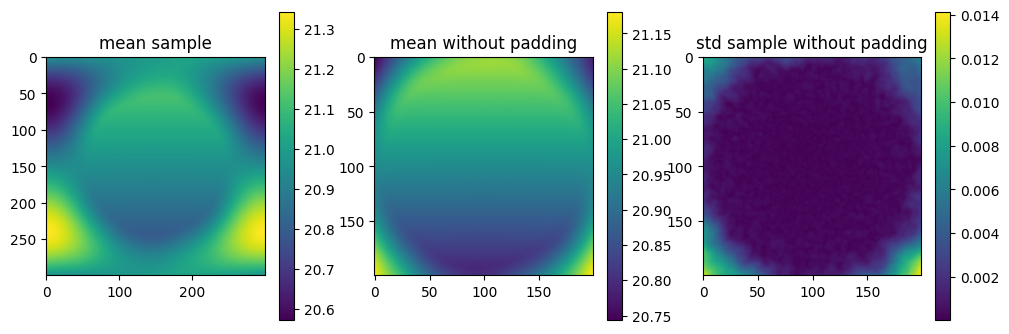

In [25]:
# n_it = 1
n_it = 5
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-5
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)
    
    im1 = axes[1].imshow(mean[padding//2:-padding//2, padding//2:-padding//2])
    axes[1].title.set_text('mean without padding')
    fig.colorbar(im1)

    im2 = axes[2].imshow(std[padding//2:-padding//2, padding//2:-padding//2])
    axes[2].title.set_text('std sample without padding')
    fig.colorbar(im2)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [26]:
printfitresults()

Fit Results (res, init, std)
fluctuations: 0.009813199534315057, 0.16871608827074525, 0.08435804413537262
loglogvarslope: -4.305014316840961, -5.0, 2.0
zeromode: 8.011330059918526, 20.95525829052564, 2.0955258290525642


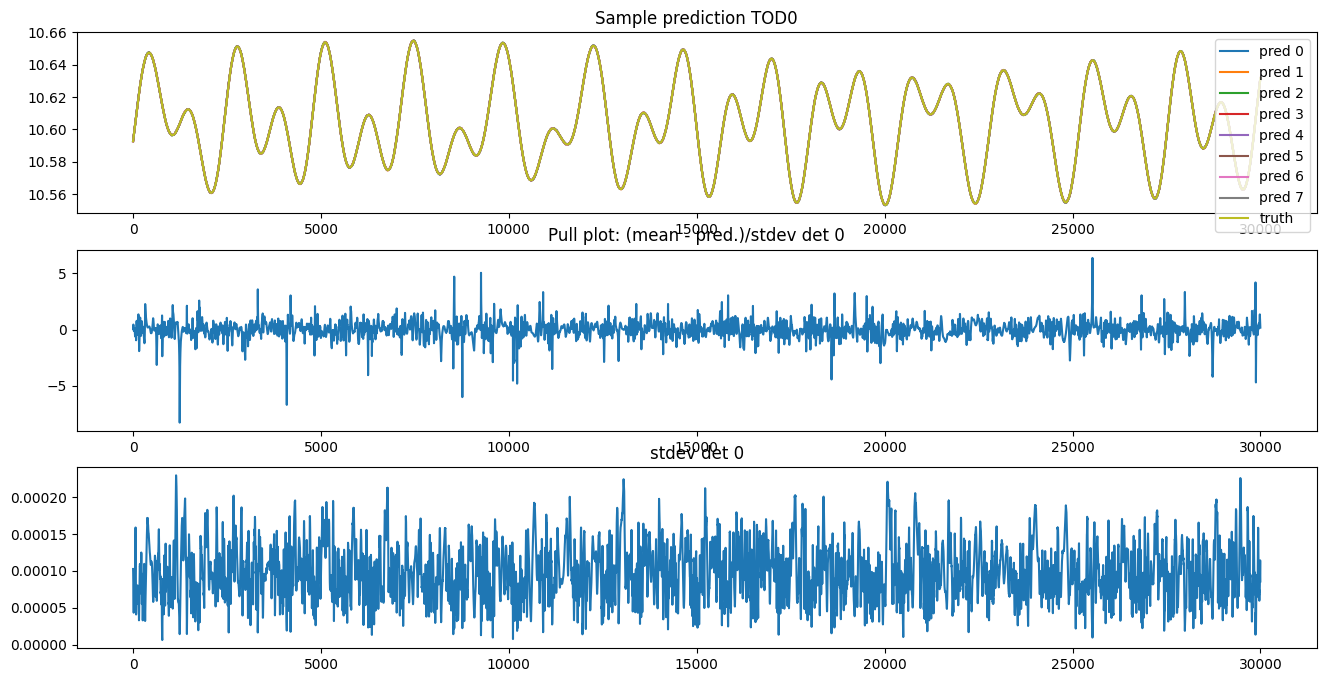

In [27]:
# plot time-series for det 0 for all samples:
fig, axes = plt.subplots(3, 1, figsize=(16, 8))

mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

i = 0
for s in samples:

    axes[0].plot(signal_response_tod(s)[0], label=f"pred {i}")
    # axes[1].plot((signal_response_tod(s)[0] - jax_tods[0])/std[0], label=i)
    i += 1

axes[0].plot(jax_tods[0], label="truth")
axes[0].set_title("Sample prediction TOD0")
axes[0].legend()

# axes[1].plot(jax_tods[0])
axes[1].plot((mean[0] - jax_tods[0])/std[0])
axes[1].set_title(f"Pull plot: (mean - pred.)/stdev det 0")

axes[2].plot(std[0])
axes[2].set_title(f"stdev det 0")

plt.show()

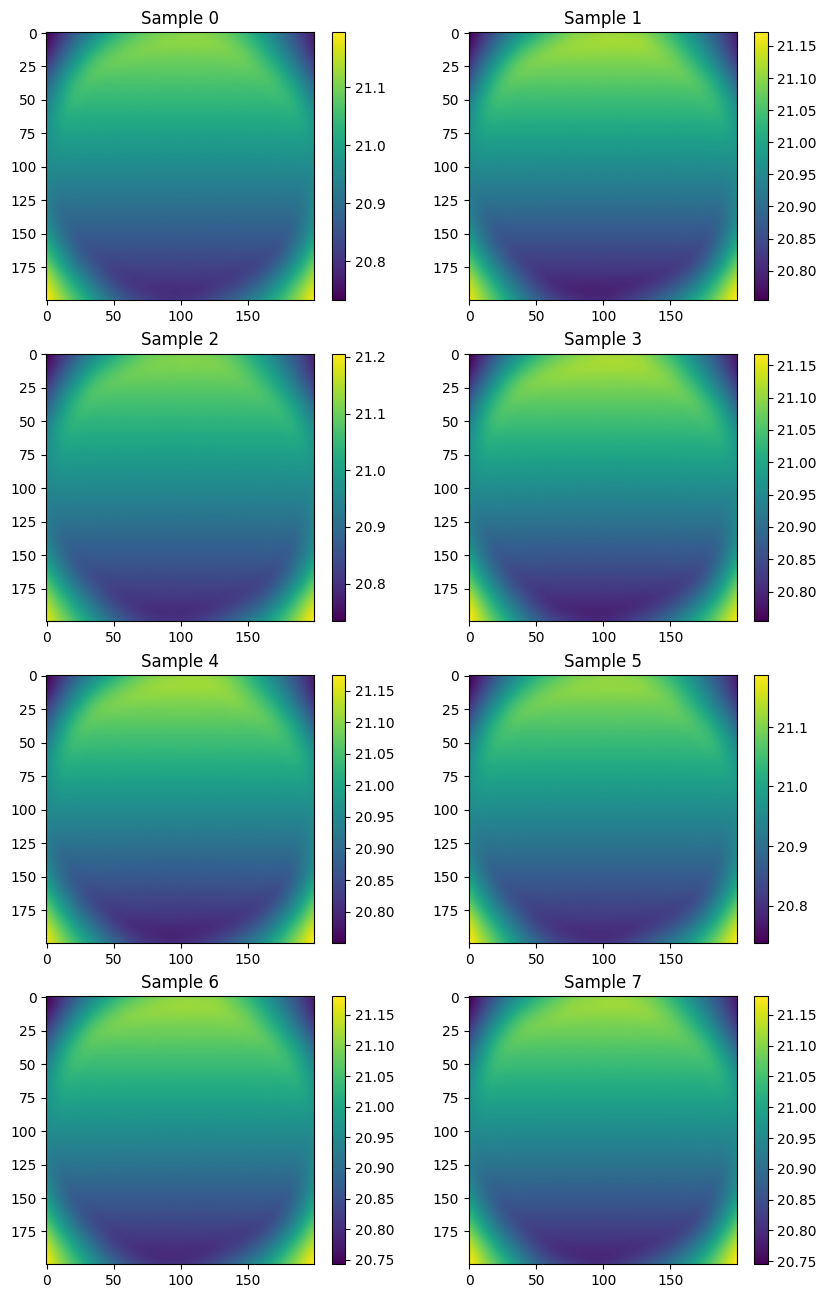

In [28]:
# plot all samples
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    # im = axes[i//4][i%4].imshow(signal_response(s))``
    im = axes[i//2][i%2].imshow(gp_map(s)[padding//2:-padding//2, padding//2:-padding//2])
    axes[i//2][i%2].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()

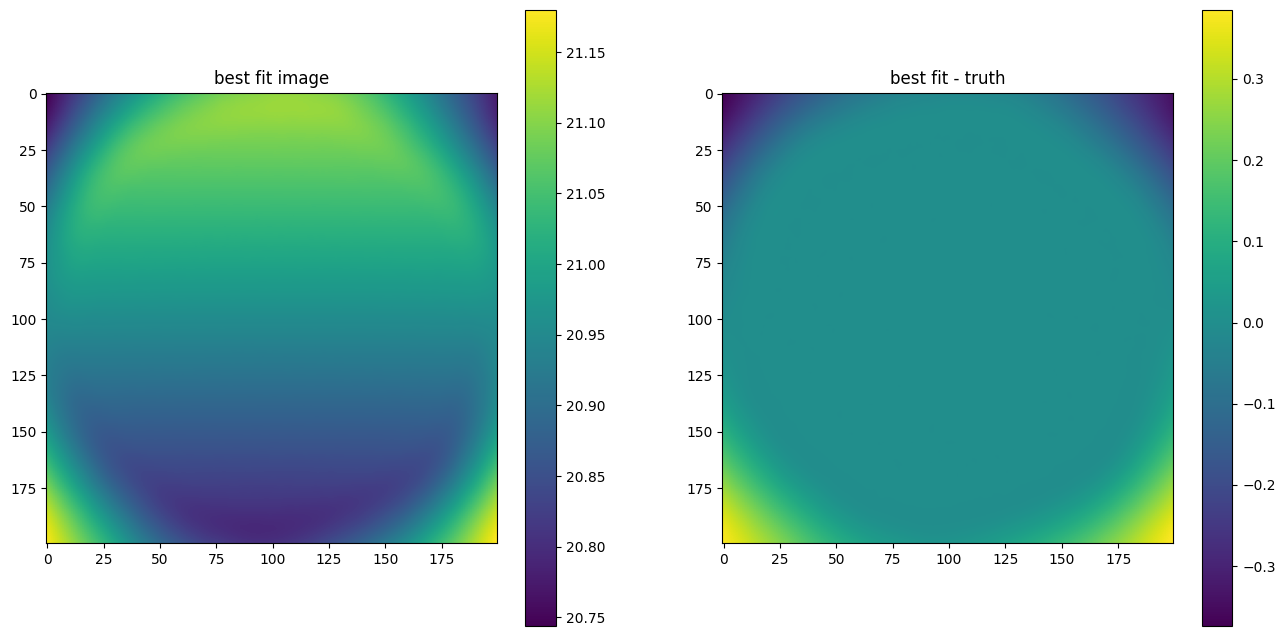

In [29]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map[padding//2:-padding//2, padding//2:-padding//2])
# im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map[padding//2:-padding//2, padding//2:-padding//2] - atmosdata_truth)
# im1 = axes[1].imshow( sig_map - atmosdata_truth)
axes[1].title.set_text('best fit - truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

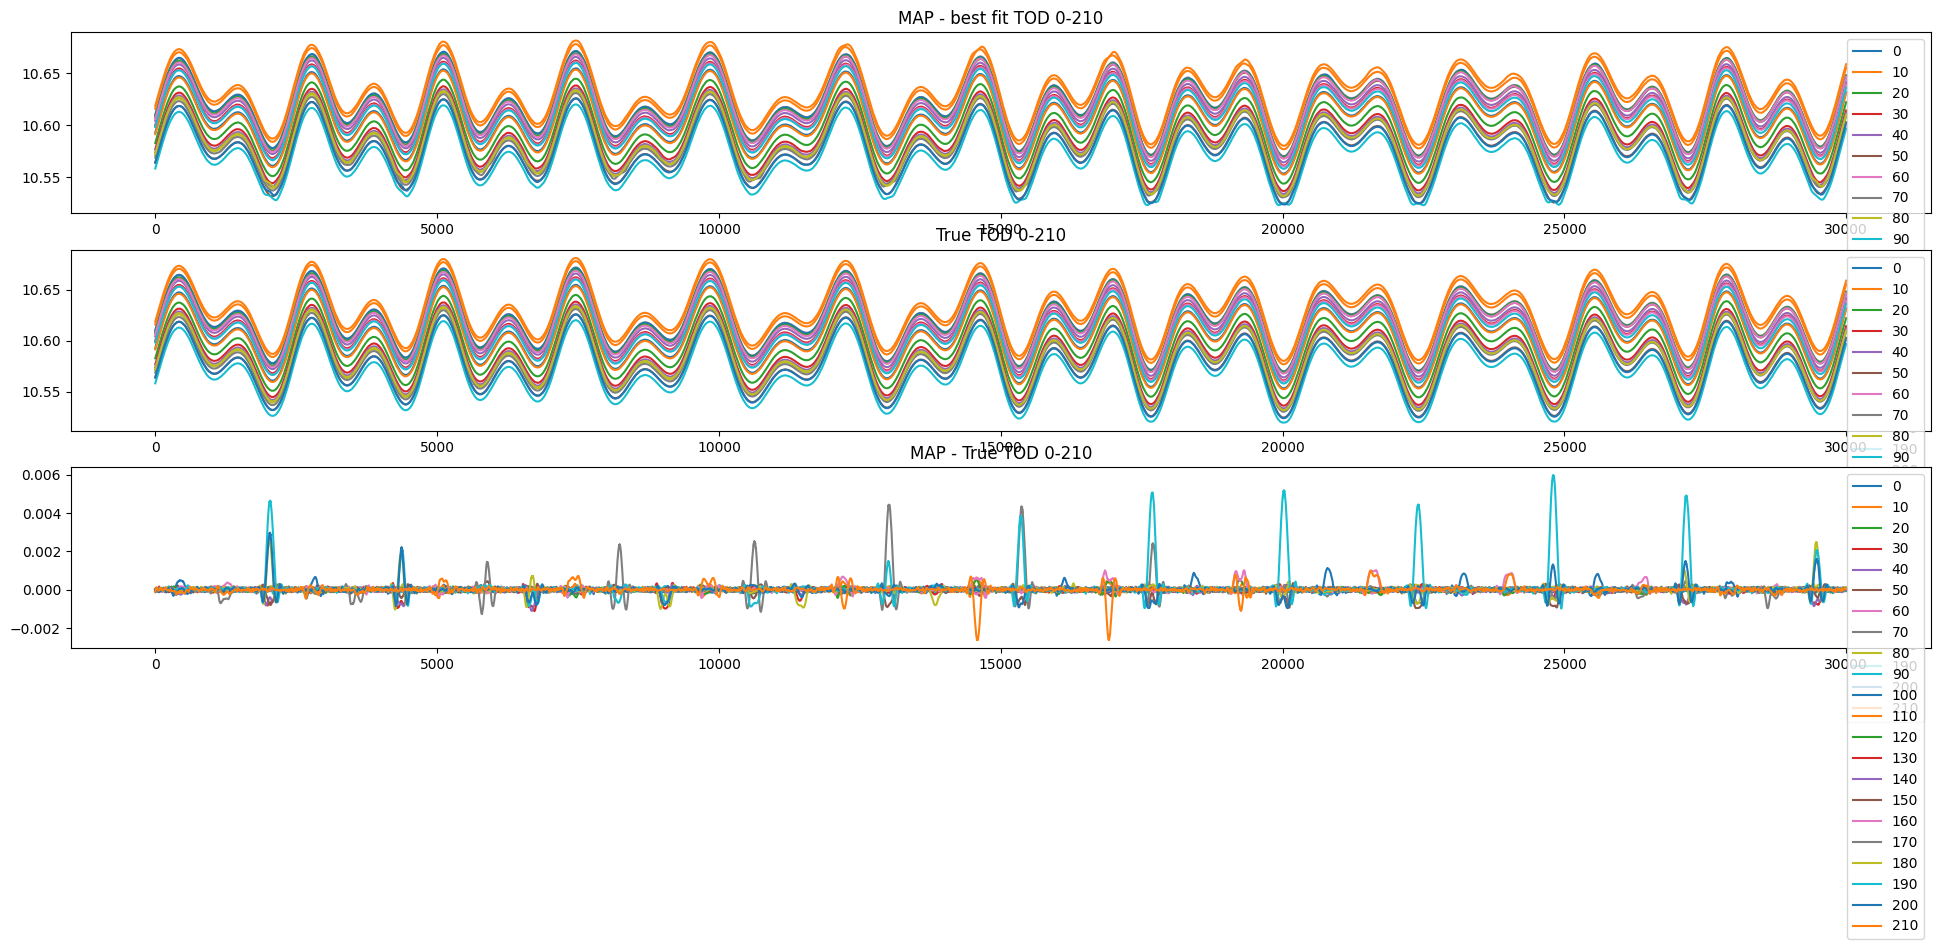

In [30]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(3, 1, figsize=(8*3, 8))

# for i in [0, 10, 100, 200]:
for i in range(0, len(jax_tods), len(jax_tods)//20):
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    im2 = axes[2].plot(pred_tods[i] - jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()
axes[2].title.set_text(f'MAP - True TOD 0-{i}')
axes[2].legend()

plt.show()